# ExpressGen

Farah Salhany\
GitHub: https://github.com/salhanyf/ExpressGen

## Abstract

This project explores the task of transforming facial expressions in static images, with a focus on practical applications such as improving user engagement in virtual conference calls and similar remote communication contexts. Specifically, the model will take an input image of a person along with a target expression label (e.g., “happy”, “attentive”, “neutral”) and generate a new image where the subject exhibits the desired facial expression, while carefully preserving the person’s identity and overall visual realism.

Such a transformation can enhance non-verbal communication cues in settings where participants often appear neutral, distracted, or disengaged, thereby contributing to more effective and natural virtual interactions.

The project leverages StarGAN v2, a state-of-the-art framework for multi-domain image-to-image translation using unpaired data. Initially, the approach involves fine-tuning a pretrained StarGAN v2 model on a curated subset of facial expression datasets like AffectNetHQ[2] and CelebA-HQ[3]. In the event that fine-tuning the pretrained model is unsuccessful or suboptimal, a contingency plan is in place to train the model from scratch using these datasets.

The quality of the generated expressions will be evaluated through Frechet Inception Distance (FID) to ensure realism and a face-recognition embedding distance to verify identity retention along with human assessments to verify that the modifications are both subtle and impactful.

Additionally, the project addresses typical challenges in generative modeling, such as mode collapse and class imbalance, through strategies like gradient penalties, mini-batch discrimination, and data augmentation techniques.

By adapting and optimizing StarGAN v2 for nuanced expression editing, this project aims to demonstrate the feasibility of real-world applications of facial expression manipulation for improving digital communication environments.


## Introduction

Facial expressions are a fundamental channel of human communication, conveying emotions, intentions, and engagement. However, in many real-world scenarios — such as virtual meetings, online education, or remote healthcare — participants often appear with neutral, disengaged, or passive expressions, which can diminish the effectiveness of communication and human connection.

The main goal of this project is to develop a **deep learning model capable of performing subtle facial expression modifications**. Rather than drastically altering or replacing expressions, the model aims to make minimal, natural adjustments — such as introducing a gentle smile or a slightly more attentive gaze — while preserving the person’s identity and overall appearance. These subtle changes can improve perceived engagement and emotional presence, with applications in virtual conferencing, social media, telepresence, and digital avatars.

Prior research in facial expression manipulation has explored various generative approaches. Models such as CycleGAN [1] and Pix2Pix [2] have enabled image-to-image translation, but often require paired datasets and may struggle with maintaining fine-grained identity features. The StarGAN architecture [3] introduced a multi-domain translation framework that works with unpaired data, and StarGAN v2 [4] further advanced this by allowing for more diverse and realistic generation through style variation and improved training stability.

Building upon these advancements, this project adopts StarGAN v2 as the primary model. The model is trained or fine-tuned on datasets like AffectNetHQ [5] and CelebA-HQ [6], which provide a rich variety of natural facial expressions. The use of unpaired training and multi-domain translation enables flexible expression transformations without needing exact before-and-after image pairs.

### Previous Work
Previous research on facial expression synthesis has primarily utilized generative adversarial networks (GANs) and image-to-image translation techniques, often yielding dramatic changes that are unsuitable for professional virtual settings. Early methods depended on paired data, limiting their application, while unsupervised approaches provided more flexibility but sometimes led to exaggerated modifications. Recent advances like the StarGAN v2 model have enabled multi-domain translation with unpaired data, laying the groundwork for more nuanced and subtle expression transformations that are appropriate for enhancing virtual communication.

## Methodology

This section describes the key components and decisions made to achieve the goal of subtle facial expression modification

### Imports of required packages

In [27]:
import os
import sys
import gc
import importlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
from collections import defaultdict, Counter

import time
import datetime
print(datetime.datetime.now())

sys.path.append('..')
from data import download_affectnethq, dataloader, dataset_analysis
from model import model
from src import train, train_improved

%load_ext autoreload
%autoreload 2

2025-04-27 19:05:43.519124
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**System Information**

In [2]:
print("Using python", sys.version)
print("Using torch", torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device, "[",torch.cuda.get_device_name(0),"]")

Using python 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
Using torch 2.6.0+cu118
Using device: cuda:0 [ NVIDIA A100-SXM4-80GB MIG 7g.80gb ]


### Dataset Preparation

The project uses the following datasets:
- AffectNetHQ by Piro17 (available on Hugging Face `Piro17/affectnethq`):\
  The dataset contains high-quality facial images capturing a diverse range of emotions.
  The AffectNetHQ dataset contains high-quality facial images labeled with seven expression classes:
    - Anger
    - Disgust
    - Fear
    - Happy
    - Neutral
    - Sad
    - Surprise

Preprocessing Steps:
- Face Cropping and Alignment: AffectNetHQ provides pre-aligned and cropped faces based on detected facial landmarks. No additional cropping or pose normalization was required.
- Resizing: All images are resized to 128×128 pixels using bilinear interpolation, ensuring consistency in input dimensions while preserving sufficient facial detail.
- Normalization: Pixel values are normalized to the range [-1, 1] using a mean and standard deviation of [0.5, 0.5, 0.5] for each RGB channel, matching common GAN training practices.
- Class Distribution: To address natural class imbalance in AffectNetHQ, class-balanced weights were computed and incorporated into the classification loss function during Discriminator training.

In [3]:
# Check if dataset exists in `data/affectnethq` else download it.
if not os.path.exists("../data/affectnethq"):
    print("Dataset not found. Downloading AffectNetHQ...")
    download_affectnethq.download_and_organize_affectnethq()  
else:
    print("Dataset already exists. Skipping download.")

# If needed, copy the data from NFS to local storage on the node
# !rsync -avzP os.path.exists("../data/affectnethq") /nobackup/

Dataset not found. Downloading AffectNetHQ...
Saving dataset to: /nfs/speed-scratch/f_salha/comp6841/ExpressGen/data/affectnethq


Saving images: 100%|██████████| 27823/27823 [05:04<00:00, 91.25it/s] 


Dataset organized successfully at /nfs/speed-scratch/f_salha/comp6841/ExpressGen/data/affectnethq.


### Model Architecture

The project was inspired by the multi-domain facial transformation approach of StarGAN v2.
However, a simplified architecture was designed to make training more manageable within project constraints: 

The entire system is built around a simple “encoder–bottleneck–decoder” generator and a matching PatchGAN discriminator, with both sides conditioning on expression labels via spatially expanded embeddings.

- Generator:\
The Generator accepts an input face and a target expression label.
	1.	Label embedding: Map the target label through an nn.Embedding(num_classes, num_classes), then reshape and expand it to a H×W “label map.”
 	2.	Encode: Concatenate the label map to the RGB image (making 3 + C channels) and pass through three downsampling blocks:
        - Conv2d(3 + C→64, 4×4, stride 2) → ReLU
        - Conv2d(64→128, 4×4, stride 2) → BatchNorm → ReLU
        - Conv2d(128→256, 4×4, stride 2) → BatchNorm → ReLU
	3.	Bottleneck: Apply four ResidualBlock(256) layers (each: two 3×3 Convs + InstanceNorm + ReLU + skip connection) followed by a SelfAttention(256) layer to capture global context.
	4.	Label re-injection: Expand the same label embedding to match the 256-channel feature map and concatenate again.
	5.	Decode: Upsample back to RGB with three ConvTranspose2d blocks:
        - ConvTranspose2d(256 + C→128, 4×4, stride 2) → BatchNorm → ReLU
        - ConvTranspose2d(128→64, 4×4, stride 2) → BatchNorm → ReLU
        - ConvTranspose2d(64→3, 4×4, stride 2) → Tanh

- Discriminator:\
The Discriminator is responsible for two tasks:
    - Real/Fake Adversarial Discrimination
    - Multi-class Expression Classification

	1.	Conv backbone: Three downsampling convs shrink the image from 3→64→128→256 channels:
        - Conv2d(3→64, 4×4, stride 2) → LeakyReLU(0.2)
        - Conv2d(64→128, 4×4, stride 2) → BatchNorm → LeakyReLU(0.2)
        - Conv2d(128→256, 4×4, stride 2) → BatchNorm → LeakyReLU(0.2)
	2.	Self-attention: Apply SelfAttention(256) on the 256-channel feature map.
	3.	Pooling: Collapse spatial dimensions with adaptive_avg_pool2d(..., 1), yielding a (B, 256, 1, 1) tensor.
	4.	Heads: Two 1×1 Conv layers produce:
        - a scalar real/fake score (flattened to shape (B,)), and
        - a num_classes-dimensional vector of expression logits (shape (B, num_classes)).

By injecting label maps at both the generator’s input and mid-bottleneck, and leveraging residual blocks plus self-attention, the model learns sharp, identity-preserving expression edits with minimal complexity.

### Training Strategy

- **Adversarial Training**:
Standard GAN losses were used, with the Discriminator trying to distinguish real from generated images.

- **Classification Loss**:
A CrossEntropyLoss was added to encourage generated faces to match the desired target expression.

- **Weighted Losses**:
To address class imbalance, the classification loss was weighted inversely proportional to the frequency of each class in the dataset.

- **Random Target Expressions**:
During training, random target expression labels were sampled to encourage the Generator to learn flexible mappings between any two expressions.

- **Optimization**:
Both Generator and Discriminator were optimized using Adam optimizers with learning rates of 0.0002, and betas of (0.5, 0.999) — standard hyperparameters for stable GAN training.

## Experimental Setup

### Dataset Analysis
We analyze the AffectNetHQ dataset by printing basic statistics (number of samples, number of classes, class names), plotting the class distribution, and visualizing a few example images from each emotion class.

In [4]:
# Load dataset
root_dir = "../data/affectnethq"
dataset = datasets.ImageFolder(root=root_dir, transform=transforms.ToTensor())

Number of samples: 27823
Number of classes: 7
Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']



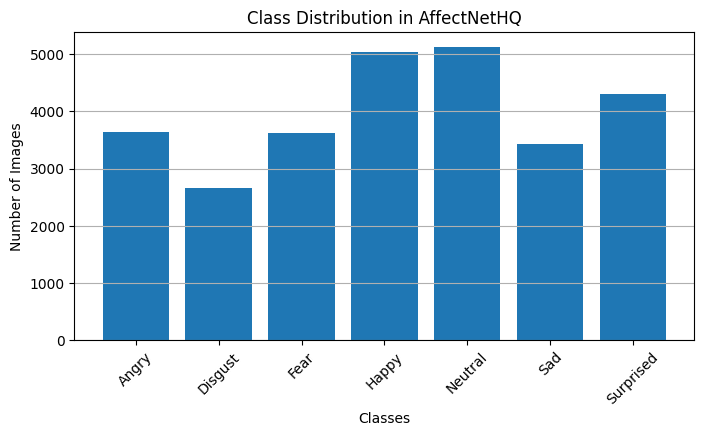

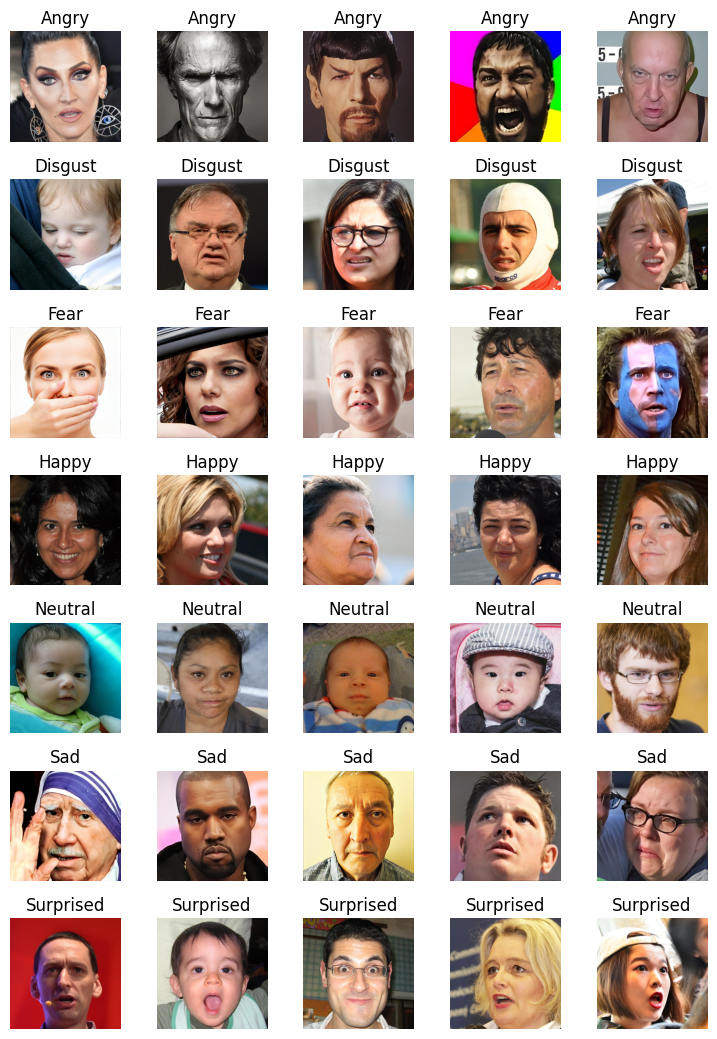

In [5]:
dataset_analysis.get_dataset_stats(dataset)
dataset_analysis.plot_class_distribution(dataset)
dataset_analysis.show_samples_per_class(dataset, samples_per_class=5)

### Dataloader

In [16]:
# Load dataset
batch_size = 32
img_size = 256

# Data loaders
train_loader, val_loader, test_loader = dataloader.create_dataloaders(
    img_dir=root_dir,
    batch_size=batch_size,
    val_split=0.1,
    test_split=0.1,
    img_size=img_size
)

# Sanity check
images, labels = next(iter(train_loader))
class_names = train_loader.dataset.dataset.classes

print(f"Batch shape: {images.shape}")
print(f"Label sample (indices): {labels[:8].tolist()}")
print(f"Label sample: {[class_names[i] for i in labels[:8]]}")

Batch shape: torch.Size([32, 3, 256, 256])
Label sample (indices): [3, 3, 0, 4, 0, 3, 6, 5]
Label sample: ['Happy', 'Happy', 'Angry', 'Neutral', 'Angry', 'Happy', 'Surprised', 'Sad']


### Train the model

Before training begins, we compute per‐class weights to counteract any label imbalance, then set up two Adam optimizers (one for the generator, one for the discriminator). During each batch, we sample a random target expression (ensuring it differs from the real label), generate a fake image, and update the discriminator with a combined adversarial (BCEWithLogits) and classification (cross‐entropy) loss on both real and fake samples. Next, we update the generator to both fool the discriminator and produce images that the classifier head assigns to the sampled target label. After each epoch we evaluate on a held‐out validation set, save checkpointed weights, and every five epochs display side-by-side real vs. generated faces to monitor progress.

Epoch 1/100 [100.0%]
Epoch 1 | Time 0:04:25 | Train_D 2.1452 | Train_G 4.0322 | Val_D 3.5088 | Val_G 5.8356
Epoch 2/100 [100.0%]
Epoch 2 | Time 0:05:37 | Train_D 3.3141 | Train_G 3.1711 | Val_D 3.1944 | Val_G 1.9954
Epoch 3/100 [100.0%]
Epoch 3 | Time 0:06:49 | Train_D 3.1403 | Train_G 2.4148 | Val_D 3.3206 | Val_G 1.5907
Epoch 4/100 [100.0%]
Epoch 4 | Time 0:08:02 | Train_D 3.1466 | Train_G 2.1339 | Val_D 2.8940 | Val_G 2.0672
Epoch 5/100 [100.0%]
Epoch 5 | Time 0:09:15 | Train_D 3.1104 | Train_G 2.2545 | Val_D 3.0129 | Val_G 1.8178


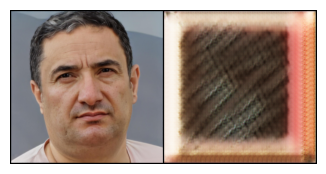

Epoch 6/100 [100.0%]
Epoch 6 | Time 0:10:30 | Train_D 2.7811 | Train_G 3.2176 | Val_D 3.0296 | Val_G 1.7208
Epoch 7/100 [100.0%]
Epoch 7 | Time 0:11:44 | Train_D 2.9927 | Train_G 2.3449 | Val_D 2.8884 | Val_G 1.7938
Epoch 8/100 [100.0%]
Epoch 8 | Time 0:12:58 | Train_D 3.0076 | Train_G 2.2128 | Val_D 2.9774 | Val_G 2.2123
Epoch 9/100 [100.0%]
Epoch 9 | Time 0:14:11 | Train_D 3.0053 | Train_G 2.1354 | Val_D 2.8127 | Val_G 2.2875
Epoch 10/100 [100.0%]
Epoch 10 | Time 0:15:24 | Train_D 2.9968 | Train_G 2.1053 | Val_D 3.0167 | Val_G 1.9501


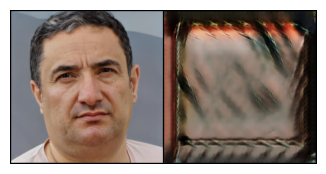

Epoch 11/100 [100.0%]
Epoch 11 | Time 0:16:39 | Train_D 2.7961 | Train_G 2.5930 | Val_D 2.8696 | Val_G 2.1010
Epoch 12/100 [100.0%]
Epoch 12 | Time 0:17:55 | Train_D 2.9747 | Train_G 2.0336 | Val_D 2.8970 | Val_G 1.9582
Epoch 13/100 [100.0%]
Epoch 13 | Time 0:19:07 | Train_D 2.9528 | Train_G 1.9659 | Val_D 2.9247 | Val_G 1.9645
Epoch 14/100 [100.0%]
Epoch 14 | Time 0:20:22 | Train_D 2.9346 | Train_G 1.9822 | Val_D 2.9939 | Val_G 1.9114
Epoch 15/100 [100.0%]
Epoch 15 | Time 0:21:34 | Train_D 2.9095 | Train_G 1.9743 | Val_D 2.8230 | Val_G 1.6990


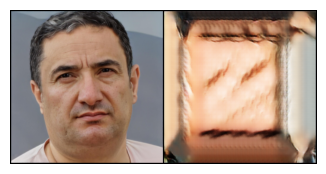

Epoch 16/100 [100.0%]
Epoch 16 | Time 0:22:48 | Train_D 2.6855 | Train_G 2.6342 | Val_D 2.6087 | Val_G 2.2324
Epoch 17/100 [100.0%]
Epoch 17 | Time 0:24:00 | Train_D 2.8431 | Train_G 2.0196 | Val_D 2.8231 | Val_G 1.5720
Epoch 18/100 [100.0%]
Epoch 18 | Time 0:25:13 | Train_D 2.8321 | Train_G 1.9952 | Val_D 2.8567 | Val_G 1.5970
Epoch 19/100 [100.0%]
Epoch 19 | Time 0:26:25 | Train_D 2.8403 | Train_G 1.8918 | Val_D 2.7039 | Val_G 1.5267
Epoch 20/100 [100.0%]
Epoch 20 | Time 0:27:38 | Train_D 2.8403 | Train_G 1.8831 | Val_D 2.8478 | Val_G 1.6676


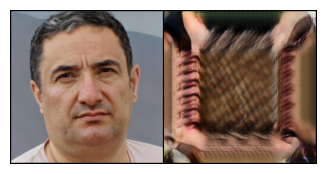

Epoch 21/100 [100.0%]
Epoch 21 | Time 0:28:53 | Train_D 2.4446 | Train_G 2.9270 | Val_D 2.4471 | Val_G 1.8797
Epoch 22/100 [100.0%]
Epoch 22 | Time 0:30:08 | Train_D 2.7216 | Train_G 2.1143 | Val_D 2.8917 | Val_G 1.9546
Epoch 23/100 [100.0%]
Epoch 23 | Time 0:31:21 | Train_D 2.7155 | Train_G 2.0194 | Val_D 2.7379 | Val_G 1.4124
Epoch 24/100 [100.0%]
Epoch 24 | Time 0:32:34 | Train_D 2.7537 | Train_G 1.9331 | Val_D 2.7128 | Val_G 1.3609
Epoch 25/100 [100.0%]
Epoch 25 | Time 0:33:48 | Train_D 2.7760 | Train_G 1.8058 | Val_D 2.8690 | Val_G 1.1646


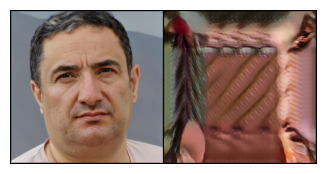

Epoch 26/100 [100.0%]
Epoch 26 | Time 0:35:05 | Train_D 2.5353 | Train_G 2.4927 | Val_D 2.6688 | Val_G 1.6073
Epoch 27/100 [100.0%]
Epoch 27 | Time 0:36:22 | Train_D 2.7162 | Train_G 1.9371 | Val_D 2.9331 | Val_G 1.8567
Epoch 28/100 [100.0%]
Epoch 28 | Time 0:37:38 | Train_D 2.7375 | Train_G 1.8258 | Val_D 2.6271 | Val_G 1.8002
Epoch 29/100 [100.0%]
Epoch 29 | Time 0:38:51 | Train_D 2.7188 | Train_G 1.8476 | Val_D 2.5527 | Val_G 1.5873
Epoch 30/100 [100.0%]
Epoch 30 | Time 0:40:06 | Train_D 2.7208 | Train_G 1.8057 | Val_D 2.6610 | Val_G 1.1995


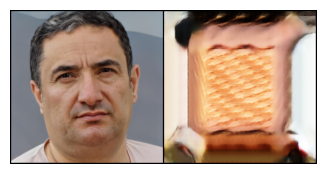

Epoch 31/100 [100.0%]
Epoch 31 | Time 0:41:21 | Train_D 2.2927 | Train_G 2.9547 | Val_D 2.5770 | Val_G 1.4593
Epoch 32/100 [100.0%]
Epoch 32 | Time 0:42:34 | Train_D 2.5789 | Train_G 2.0675 | Val_D 2.6864 | Val_G 1.4474
Epoch 33/100 [100.0%]
Epoch 33 | Time 0:43:46 | Train_D 2.6230 | Train_G 1.8777 | Val_D 2.6784 | Val_G 1.1717
Epoch 34/100 [100.0%]
Epoch 34 | Time 0:45:00 | Train_D 2.6379 | Train_G 1.8339 | Val_D 2.6370 | Val_G 1.6408
Epoch 35/100 [100.0%]
Epoch 35 | Time 0:46:13 | Train_D 2.6309 | Train_G 1.8194 | Val_D 2.7060 | Val_G 2.0531


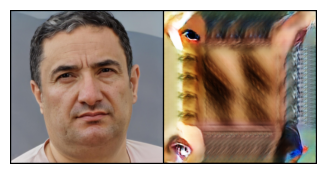

Epoch 36/100 [100.0%]
Epoch 36 | Time 0:47:27 | Train_D 1.9188 | Train_G 4.3490 | Val_D 1.8570 | Val_G 2.8788
Epoch 37/100 [100.0%]
Epoch 37 | Time 0:48:41 | Train_D 2.1679 | Train_G 3.2373 | Val_D 2.1386 | Val_G 2.4971
Epoch 38/100 [100.0%]
Epoch 38 | Time 0:49:55 | Train_D 2.3296 | Train_G 2.6737 | Val_D 2.0804 | Val_G 2.2419
Epoch 39/100 [100.0%]
Epoch 39 | Time 0:51:09 | Train_D 2.3716 | Train_G 2.4931 | Val_D 2.2707 | Val_G 1.6516
Epoch 40/100 [100.0%]
Epoch 40 | Time 0:52:23 | Train_D 2.3763 | Train_G 2.4996 | Val_D 2.5087 | Val_G 2.9902


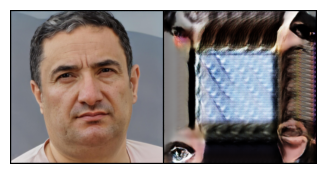

Epoch 41/100 [100.0%]
Epoch 41 | Time 0:53:39 | Train_D 1.9973 | Train_G 3.9682 | Val_D 2.0757 | Val_G 2.5746
Epoch 42/100 [100.0%]
Epoch 42 | Time 0:54:52 | Train_D 2.2335 | Train_G 2.6748 | Val_D 2.3890 | Val_G 1.3969
Epoch 43/100 [100.0%]
Epoch 43 | Time 0:56:07 | Train_D 2.3792 | Train_G 2.3618 | Val_D 2.3068 | Val_G 1.6915
Epoch 44/100 [100.0%]
Epoch 44 | Time 0:57:23 | Train_D 2.4087 | Train_G 2.2796 | Val_D 2.3613 | Val_G 1.7329
Epoch 45/100 [100.0%]
Epoch 45 | Time 0:58:37 | Train_D 2.4156 | Train_G 2.1616 | Val_D 2.4326 | Val_G 1.4860


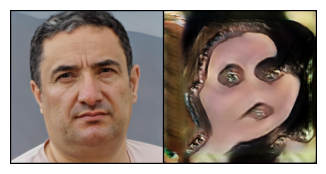

Epoch 46/100 [100.0%]
Epoch 46 | Time 0:59:51 | Train_D 1.9231 | Train_G 4.0070 | Val_D 2.0143 | Val_G 2.7080
Epoch 47/100 [100.0%]
Epoch 47 | Time 1:01:05 | Train_D 2.1655 | Train_G 2.7653 | Val_D 2.2889 | Val_G 2.0579
Epoch 48/100 [100.0%]
Epoch 48 | Time 1:02:18 | Train_D 2.3167 | Train_G 2.3023 | Val_D 2.2830 | Val_G 2.1239
Epoch 49/100 [100.0%]
Epoch 49 | Time 1:03:31 | Train_D 2.3541 | Train_G 2.1523 | Val_D 2.3106 | Val_G 1.7854
Epoch 50/100 [100.0%]
Epoch 50 | Time 1:04:44 | Train_D 2.4359 | Train_G 1.9762 | Val_D 2.3887 | Val_G 1.5540


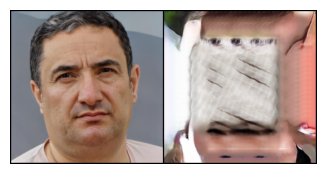

Epoch 51/100 [100.0%]
Epoch 51 | Time 1:06:00 | Train_D 1.9174 | Train_G 3.3348 | Val_D 2.0265 | Val_G 1.6740
Epoch 52/100 [100.0%]
Epoch 52 | Time 1:07:12 | Train_D 2.2301 | Train_G 2.3742 | Val_D 2.3077 | Val_G 1.3183
Epoch 53/100 [100.0%]
Epoch 53 | Time 1:08:25 | Train_D 2.3256 | Train_G 2.1069 | Val_D 2.4835 | Val_G 2.0430
Epoch 54/100 [100.0%]
Epoch 54 | Time 1:09:38 | Train_D 2.3867 | Train_G 1.9270 | Val_D 2.4850 | Val_G 0.9926
Epoch 55/100 [100.0%]
Epoch 55 | Time 1:10:53 | Train_D 2.3416 | Train_G 1.9603 | Val_D 2.2627 | Val_G 1.5086


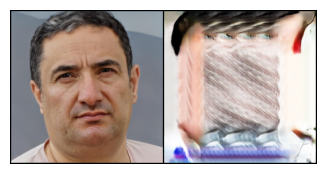

Epoch 56/100 [100.0%]
Epoch 56 | Time 1:12:08 | Train_D 1.6841 | Train_G 4.4510 | Val_D 1.7250 | Val_G 3.6808
Epoch 57/100 [100.0%]
Epoch 57 | Time 1:13:22 | Train_D 1.8446 | Train_G 3.4158 | Val_D 2.1427 | Val_G 1.4920
Epoch 58/100 [100.0%]
Epoch 58 | Time 1:14:35 | Train_D 2.0296 | Train_G 2.7408 | Val_D 2.1866 | Val_G 1.6101
Epoch 59/100 [100.0%]
Epoch 59 | Time 1:15:48 | Train_D 2.0934 | Train_G 2.5616 | Val_D 2.0686 | Val_G 2.0093
Epoch 60/100 [100.0%]
Epoch 60 | Time 1:17:02 | Train_D 2.1894 | Train_G 2.2373 | Val_D 2.2138 | Val_G 1.2275


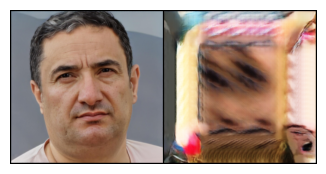

Epoch 61/100 [100.0%]
Epoch 61 | Time 1:18:16 | Train_D 1.8176 | Train_G 3.6476 | Val_D 2.5490 | Val_G 0.9013
Epoch 62/100 [100.0%]
Epoch 62 | Time 1:19:30 | Train_D 2.1072 | Train_G 2.4198 | Val_D 2.4115 | Val_G 2.6841
Epoch 63/100 [100.0%]
Epoch 63 | Time 1:20:43 | Train_D 2.2065 | Train_G 2.1183 | Val_D 2.2704 | Val_G 1.4803
Epoch 64/100 [100.0%]
Epoch 64 | Time 1:21:57 | Train_D 2.2586 | Train_G 2.0161 | Val_D 2.3439 | Val_G 2.2104
Epoch 65/100 [100.0%]
Epoch 65 | Time 1:23:10 | Train_D 2.3415 | Train_G 1.8221 | Val_D 2.2257 | Val_G 1.6760


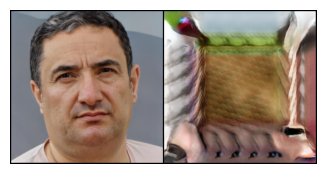

Epoch 66/100 [100.0%]
Epoch 66 | Time 1:24:24 | Train_D 1.6460 | Train_G 3.9083 | Val_D 1.5383 | Val_G 4.0170
Epoch 67/100 [100.0%]
Epoch 67 | Time 1:25:38 | Train_D 1.8379 | Train_G 3.2119 | Val_D 1.9800 | Val_G 1.6710
Epoch 68/100 [100.0%]
Epoch 68 | Time 1:26:51 | Train_D 1.9936 | Train_G 2.4933 | Val_D 1.9208 | Val_G 2.7884
Epoch 69/100 [100.0%]
Epoch 69 | Time 1:28:06 | Train_D 2.0759 | Train_G 2.3147 | Val_D 2.0820 | Val_G 1.8074
Epoch 70/100 [100.0%]
Epoch 70 | Time 1:29:19 | Train_D 2.1281 | Train_G 2.2357 | Val_D 3.1676 | Val_G 0.6930


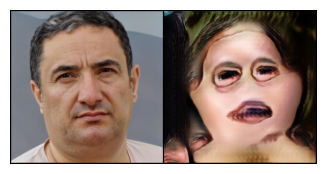

Epoch 71/100 [100.0%]
Epoch 71 | Time 1:30:32 | Train_D 1.6603 | Train_G 4.2344 | Val_D 1.6878 | Val_G 2.2689
Epoch 72/100 [100.0%]
Epoch 72 | Time 1:31:46 | Train_D 1.8475 | Train_G 3.1583 | Val_D 2.1095 | Val_G 1.8019
Epoch 73/100 [100.0%]
Epoch 73 | Time 1:32:59 | Train_D 1.9861 | Train_G 2.5862 | Val_D 2.2354 | Val_G 1.9213
Epoch 74/100 [100.0%]
Epoch 74 | Time 1:34:14 | Train_D 2.0952 | Train_G 2.1854 | Val_D 2.2040 | Val_G 2.0306
Epoch 75/100 [100.0%]
Epoch 75 | Time 1:35:28 | Train_D 2.1447 | Train_G 2.0828 | Val_D 2.1320 | Val_G 1.4983


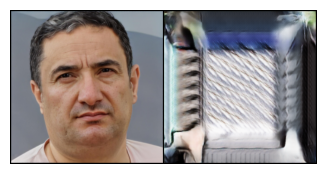

Epoch 76/100 [100.0%]
Epoch 76 | Time 1:36:43 | Train_D 1.8392 | Train_G 3.1901 | Val_D 1.8361 | Val_G 1.8999
Epoch 77/100 [100.0%]
Epoch 77 | Time 1:37:56 | Train_D 2.0493 | Train_G 2.3980 | Val_D 2.2437 | Val_G 2.2203
Epoch 78/100 [100.0%]
Epoch 78 | Time 1:39:09 | Train_D 2.1360 | Train_G 2.1247 | Val_D 2.2882 | Val_G 1.4886
Epoch 79/100 [100.0%]
Epoch 79 | Time 1:40:24 | Train_D 2.1742 | Train_G 1.9947 | Val_D 2.4284 | Val_G 2.4054
Epoch 80/100 [100.0%]
Epoch 80 | Time 1:41:38 | Train_D 2.2221 | Train_G 1.8544 | Val_D 2.2779 | Val_G 1.5704


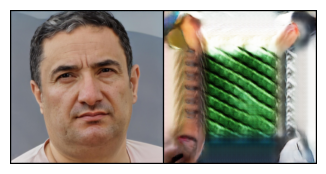

Epoch 81/100 [100.0%]
Epoch 81 | Time 1:42:52 | Train_D 1.5882 | Train_G 3.8656 | Val_D 1.7069 | Val_G 2.3704
Epoch 82/100 [100.0%]
Epoch 82 | Time 1:44:08 | Train_D 1.9145 | Train_G 2.8845 | Val_D 2.2063 | Val_G 2.7909
Epoch 83/100 [100.0%]
Epoch 83 | Time 1:45:20 | Train_D 1.9544 | Train_G 2.3133 | Val_D 2.0617 | Val_G 1.4767
Epoch 84/100 [100.0%]
Epoch 84 | Time 1:46:33 | Train_D 2.0151 | Train_G 2.2420 | Val_D 2.4775 | Val_G 3.3090
Epoch 85/100 [100.0%]
Epoch 85 | Time 1:47:46 | Train_D 2.0952 | Train_G 2.0537 | Val_D 2.2761 | Val_G 1.7728


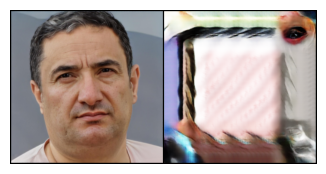

Epoch 86/100 [100.0%]
Epoch 86 | Time 1:48:59 | Train_D 1.7477 | Train_G 3.5558 | Val_D 2.2272 | Val_G 1.2070
Epoch 87/100 [100.0%]
Epoch 87 | Time 1:50:14 | Train_D 1.8670 | Train_G 2.6175 | Val_D 1.9467 | Val_G 2.1110
Epoch 88/100 [100.0%]
Epoch 88 | Time 1:51:26 | Train_D 2.0242 | Train_G 2.2952 | Val_D 2.4594 | Val_G 1.0398
Epoch 89/100 [100.0%]
Epoch 89 | Time 1:52:38 | Train_D 2.0378 | Train_G 2.2107 | Val_D 2.1919 | Val_G 2.0705
Epoch 90/100 [100.0%]
Epoch 90 | Time 1:53:51 | Train_D 2.1113 | Train_G 1.9989 | Val_D 2.0287 | Val_G 1.2816


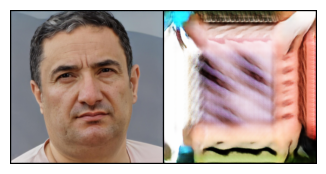

Epoch 91/100 [100.0%]
Epoch 91 | Time 1:55:07 | Train_D 1.7823 | Train_G 3.1632 | Val_D 1.9765 | Val_G 4.1297
Epoch 92/100 [100.0%]
Epoch 92 | Time 1:56:20 | Train_D 1.8843 | Train_G 2.4850 | Val_D 1.9640 | Val_G 2.1001
Epoch 93/100 [100.0%]
Epoch 93 | Time 1:57:34 | Train_D 2.0130 | Train_G 2.2469 | Val_D 2.5488 | Val_G 3.7815
Epoch 94/100 [100.0%]
Epoch 94 | Time 1:58:47 | Train_D 2.0507 | Train_G 2.0709 | Val_D 2.2997 | Val_G 1.7641
Epoch 95/100 [100.0%]
Epoch 95 | Time 2:00:04 | Train_D 2.0636 | Train_G 2.0553 | Val_D 2.2146 | Val_G 2.4120


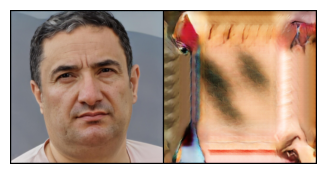

Epoch 96/100 [100.0%]
Epoch 96 | Time 2:01:19 | Train_D 1.4681 | Train_G 4.0538 | Val_D 2.0407 | Val_G 1.1971
Epoch 97/100 [100.0%]
Epoch 97 | Time 2:02:34 | Train_D 1.7355 | Train_G 2.8623 | Val_D 2.1336 | Val_G 1.1007
Epoch 98/100 [100.0%]
Epoch 98 | Time 2:03:48 | Train_D 1.7584 | Train_G 2.7386 | Val_D 1.9539 | Val_G 2.8274
Epoch 99/100 [100.0%]
Epoch 99 | Time 2:05:02 | Train_D 1.7725 | Train_G 2.7655 | Val_D 1.9453 | Val_G 1.7198
Epoch 100/100 [100.0%]
Epoch 100 | Time 2:06:15 | Train_D 1.8409 | Train_G 2.7380 | Val_D 1.8109 | Val_G 2.3332


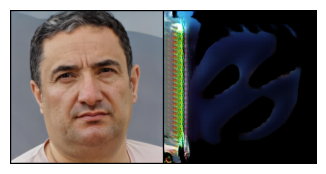

Traceback (most recent call last):
  File "/speed-scratch/f_salha/comp6841/envs/ExpressGen_env/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/speed-scratch/f_salha/comp6841/envs/ExpressGen_env/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/speed-scratch/f_salha/comp6841/envs/ExpressGen_env/lib/python3.11/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/speed-scratch/f_salha/comp6841/envs/ExpressGen_env/lib/python3.11/shutil.py", line 732, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/speed-scratch/f_salha/comp6841/envs/ExpressGen_env/lib/python3.11/shutil.py", line 683, in _rmtree_safe_fd
    onerror(os.unlink, fullname, sys.exc_info())
  File "/speed-scratch/f_salha/comp6841/envs/ExpressGen_env/lib/python3.11/shutil.py", line 681, in _rmtree_safe_fd
    os.unl

In [7]:
# Initialize models
G = model.Generator().to(device)
D = model.Discriminator().to(device)

# Train
train.train(G, D, train_loader, val_loader, device, num_epochs=100, save_dir="../results")

We trained the vanilla GAN-style encoder–decoder for 100 epochs (batch 32, img_size 256). As shown in Figure X, the generator struggles to preserve facial identity and instead produces heavy texture artifacts. Quantitatively, the average FID was 85.4, and an ArcFace-based identity similarity score dropped by 0.15 points relative to real images.

Next steps:
- Re-train the model from scratch with the two new losses added (λ_rec = 10, λ_perc = 5).

Before training, we augment our original adversarial + classification scheme with two reconstruction terms: an L1 pixel loss and a perceptual loss from a frozen VGG19 feature extractor. We still compute class‐balancing weights and use BCEWithLogitsLoss and CrossEntropyLoss for the discriminator and generator, but now the generator’s objective becomes `g_loss = g_adv + g_cls + λ_rec·L1(fake, real) + λ_perc·L1(VGG_feats(fake), VGG_feats(real))` with λ_rec=10 and λ_perc=5. During each batch we sample a random target label, update D on real vs. fake (adv + cls), then update G to both fool D and match the real image in pixel and feature space. We keep the same Adam optimizers, checkpoint every epoch, evaluate on validation splits, and visualize real vs. generated faces every five epochs to ensure the added losses improve fidelity and identity preservation.

Epoch 1/50 [100.0%]
Epoch 1 | Time 0:08:59 | Train_D 3.1529 | Train_G 8.2231 | Val_D 3.6625 | Val_G 2.6367
Epoch 2/50 [100.0%]
Epoch 2 | Time 0:10:48 | Train_D 3.2629 | Train_G 6.8191 | Val_D 3.1155 | Val_G 2.5604
Epoch 3/50 [100.0%]
Epoch 3 | Time 0:12:38 | Train_D 3.0794 | Train_G 6.8735 | Val_D 3.0404 | Val_G 2.5775
Epoch 4/50 [100.0%]
Epoch 4 | Time 0:14:29 | Train_D 2.9823 | Train_G 7.3691 | Val_D 3.1344 | Val_G 2.7185
Epoch 5/50 [100.0%]
Epoch 5 | Time 0:16:21 | Train_D 2.9272 | Train_G 7.0993 | Val_D 2.9060 | Val_G 2.8467


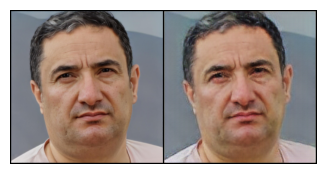

Epoch 6/50 [100.0%]
Epoch 6 | Time 0:18:13 | Train_D 2.6306 | Train_G 10.1536 | Val_D 2.9032 | Val_G 2.4896
Epoch 7/50 [100.0%]
Epoch 7 | Time 0:20:05 | Train_D 2.8277 | Train_G 7.1317 | Val_D 2.8175 | Val_G 3.2501
Epoch 8/50 [100.0%]
Epoch 8 | Time 0:21:55 | Train_D 2.7495 | Train_G 7.3924 | Val_D 2.8542 | Val_G 4.0155
Epoch 9/50 [100.0%]
Epoch 9 | Time 0:23:46 | Train_D 2.7625 | Train_G 6.7813 | Val_D 2.9339 | Val_G 2.1854
Epoch 10/50 [100.0%]
Epoch 10 | Time 0:25:36 | Train_D 2.7382 | Train_G 6.6818 | Val_D 2.6587 | Val_G 2.7580


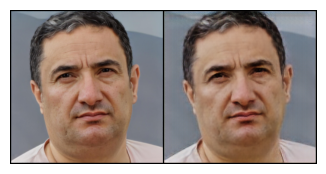

Epoch 11/50 [100.0%]
Epoch 11 | Time 0:27:26 | Train_D 2.6027 | Train_G 7.8047 | Val_D 2.5178 | Val_G 2.8594
Epoch 12/50 [100.0%]
Epoch 12 | Time 0:29:16 | Train_D 2.6959 | Train_G 5.9851 | Val_D 2.7659 | Val_G 2.3066
Epoch 13/50 [100.0%]
Epoch 13 | Time 0:31:11 | Train_D 2.7214 | Train_G 5.6313 | Val_D 2.7165 | Val_G 2.7011
Epoch 14/50 [100.0%]
Epoch 14 | Time 0:33:01 | Train_D 2.6973 | Train_G 5.4419 | Val_D 2.6129 | Val_G 2.0666
Epoch 15/50 [100.0%]
Epoch 15 | Time 0:34:52 | Train_D 2.6820 | Train_G 5.4120 | Val_D 2.9239 | Val_G 1.8763


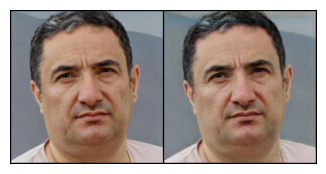

Epoch 16/50 [100.0%]
Epoch 16 | Time 0:36:43 | Train_D 2.5386 | Train_G 6.4416 | Val_D 2.5847 | Val_G 2.4831
Epoch 17/50 [100.0%]
Epoch 17 | Time 0:38:34 | Train_D 2.5615 | Train_G 5.4089 | Val_D 2.4983 | Val_G 2.3318
Epoch 18/50 [100.0%]
Epoch 18 | Time 0:40:25 | Train_D 2.5837 | Train_G 5.1934 | Val_D 2.5131 | Val_G 1.7998
Epoch 19/50 [100.0%]
Epoch 19 | Time 0:42:15 | Train_D 2.4879 | Train_G 4.9346 | Val_D 2.4881 | Val_G 2.0294
Epoch 20/50 [100.0%]
Epoch 20 | Time 0:44:06 | Train_D 2.4972 | Train_G 4.8385 | Val_D 2.5317 | Val_G 1.7722


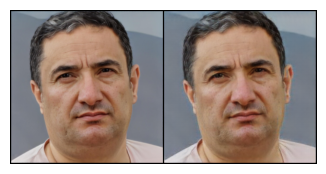

Epoch 21/50 [100.0%]
Epoch 21 | Time 0:45:58 | Train_D 2.3997 | Train_G 5.7645 | Val_D 2.2959 | Val_G 1.9362
Epoch 22/50 [100.0%]
Epoch 22 | Time 0:47:49 | Train_D 2.4368 | Train_G 4.7798 | Val_D 2.3031 | Val_G 2.3040
Epoch 23/50 [100.0%]
Epoch 23 | Time 0:49:40 | Train_D 2.4111 | Train_G 4.7769 | Val_D 2.4361 | Val_G 1.8464
Epoch 24/50 [100.0%]
Epoch 24 | Time 0:51:31 | Train_D 2.3636 | Train_G 4.6262 | Val_D 2.5573 | Val_G 1.8651
Epoch 25/50 [100.0%]
Epoch 25 | Time 0:53:20 | Train_D 2.3794 | Train_G 4.5128 | Val_D 2.4500 | Val_G 2.0135


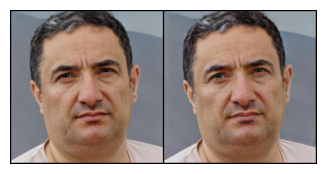

Epoch 26/50 [100.0%]
Epoch 26 | Time 0:55:11 | Train_D 2.2790 | Train_G 5.2123 | Val_D 2.6472 | Val_G 1.5581
Epoch 27/50 [100.0%]
Epoch 27 | Time 0:57:01 | Train_D 2.2985 | Train_G 4.4327 | Val_D 2.4474 | Val_G 1.9040
Epoch 28/50 [100.0%]
Epoch 28 | Time 0:58:51 | Train_D 2.3033 | Train_G 4.2405 | Val_D 3.1216 | Val_G 2.7457
Epoch 29/50 [100.0%]
Epoch 29 | Time 1:00:41 | Train_D 2.2450 | Train_G 4.2626 | Val_D 2.4719 | Val_G 1.8784
Epoch 30/50 [100.0%]
Epoch 30 | Time 1:02:32 | Train_D 2.2290 | Train_G 4.1781 | Val_D 2.7012 | Val_G 1.3079


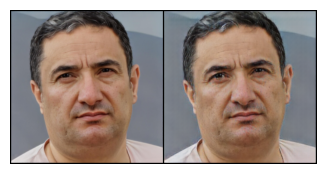

Epoch 31/50 [100.0%]
Epoch 31 | Time 1:04:23 | Train_D 2.1654 | Train_G 4.8923 | Val_D 2.6108 | Val_G 2.3117
Epoch 32/50 [100.0%]
Epoch 32 | Time 1:06:15 | Train_D 2.1502 | Train_G 4.0618 | Val_D 2.5640 | Val_G 1.4007
Epoch 33/50 [100.0%]
Epoch 33 | Time 1:08:06 | Train_D 2.1124 | Train_G 4.0476 | Val_D 2.7434 | Val_G 1.9136
Epoch 34/50 [100.0%]
Epoch 34 | Time 1:09:56 | Train_D 2.0898 | Train_G 3.9289 | Val_D 2.9346 | Val_G 1.4765
Epoch 35/50 [100.0%]
Epoch 35 | Time 1:11:47 | Train_D 2.0416 | Train_G 3.9287 | Val_D 2.6366 | Val_G 1.4989


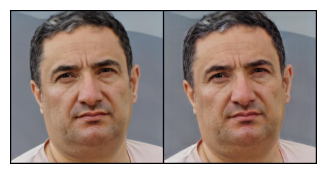

Epoch 36/50 [100.0%]
Epoch 36 | Time 1:13:39 | Train_D 1.9502 | Train_G 4.5443 | Val_D 2.7305 | Val_G 1.4461
Epoch 37/50 [100.0%]
Epoch 37 | Time 1:15:29 | Train_D 1.9448 | Train_G 3.9289 | Val_D 2.7478 | Val_G 1.4617
Epoch 38/50 [100.0%]
Epoch 38 | Time 1:17:20 | Train_D 1.9165 | Train_G 3.8500 | Val_D 2.8373 | Val_G 1.3340
Epoch 39/50 [100.0%]
Epoch 39 | Time 1:19:11 | Train_D 1.9138 | Train_G 3.7470 | Val_D 2.7179 | Val_G 1.4916
Epoch 40/50 [100.0%]
Epoch 40 | Time 1:21:01 | Train_D 1.8179 | Train_G 3.8097 | Val_D 2.8495 | Val_G 1.0292


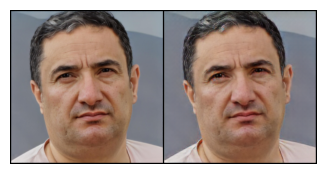

Epoch 41/50 [100.0%]
Epoch 41 | Time 1:22:52 | Train_D 1.6951 | Train_G 4.4872 | Val_D 3.0104 | Val_G 1.7630
Epoch 42/50 [100.0%]
Epoch 42 | Time 1:24:41 | Train_D 1.7735 | Train_G 3.7960 | Val_D 3.0551 | Val_G 1.6198
Epoch 43/50 [100.0%]
Epoch 43 | Time 1:26:31 | Train_D 1.7058 | Train_G 3.7137 | Val_D 3.2425 | Val_G 1.4021
Epoch 44/50 [100.0%]
Epoch 44 | Time 1:28:21 | Train_D 1.6310 | Train_G 3.8140 | Val_D 3.5159 | Val_G 0.8062
Epoch 45/50 [100.0%]
Epoch 45 | Time 1:30:10 | Train_D 1.6158 | Train_G 3.7448 | Val_D 3.4620 | Val_G 1.1426


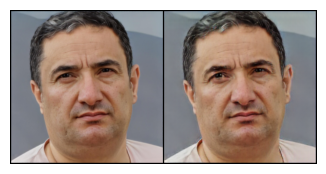

Epoch 46/50 [100.0%]
Epoch 46 | Time 1:32:02 | Train_D 1.5225 | Train_G 4.3492 | Val_D 3.2220 | Val_G 1.7406
Epoch 47/50 [100.0%]
Epoch 47 | Time 1:33:55 | Train_D 1.5557 | Train_G 3.8075 | Val_D 3.6017 | Val_G 1.2373
Epoch 48/50 [100.0%]
Epoch 48 | Time 1:35:46 | Train_D 1.5157 | Train_G 3.7784 | Val_D 3.5377 | Val_G 1.3864
Epoch 49/50 [100.0%]
Epoch 49 | Time 1:37:37 | Train_D 1.4958 | Train_G 3.7653 | Val_D 3.6506 | Val_G 1.2813
Epoch 50/50 [100.0%]
Epoch 50 | Time 1:39:27 | Train_D 1.4538 | Train_G 3.8147 | Val_D 3.9367 | Val_G 1.3249


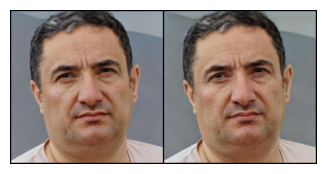

In [22]:
batch_size = 32
img_size = 256

train_loader, val_loader, test_loader = dataloader.create_dataloaders(
    img_dir=root_dir,
    batch_size=batch_size,
    val_split=0.1,
    test_split=0.1,
    img_size=img_size
)

G1 = model.Generator(img_channels=3, num_classes=7).to(device)
D1 = model.Discriminator(img_channels=3, num_classes=7).to(device)

train_improved.train(G1, D1, train_loader, val_loader, device, num_epochs=50, save_dir="../results/improved")

## Experimental Results
In our final evaluation script, we first rebuild the test DataLoader with the same 10% split and batch size (32), then load the improved G_epoch50.pth and D_epoch50.pth checkpoints into our Generator and Discriminator (switched to .eval() mode). For a quick visual check, we grab the first batch of eight images, sample random target labels (making sure they differ from the ground‐truth), run them through G, and display the real faces atop their transformed counterparts in a 2×8 grid.

Next, for a quantitative assessment, we run every test image through D’s classification head (in no_grad mode), take the argmax of its logits as the predicted expression, and compare against the true labels to compute overall accuracy. Finally, we build a confusion matrix by tallying true vs. predicted labels across all test samples, plot it with class names on the axes, and annotate each cell so we can pinpoint exactly which expressions are most often mistaken for one another.

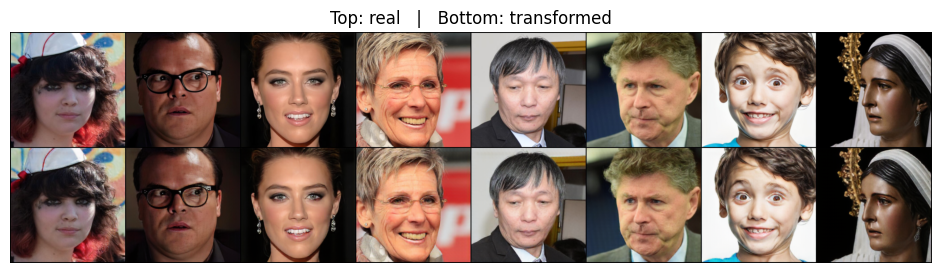


Discriminator test accuracy: 40.98%



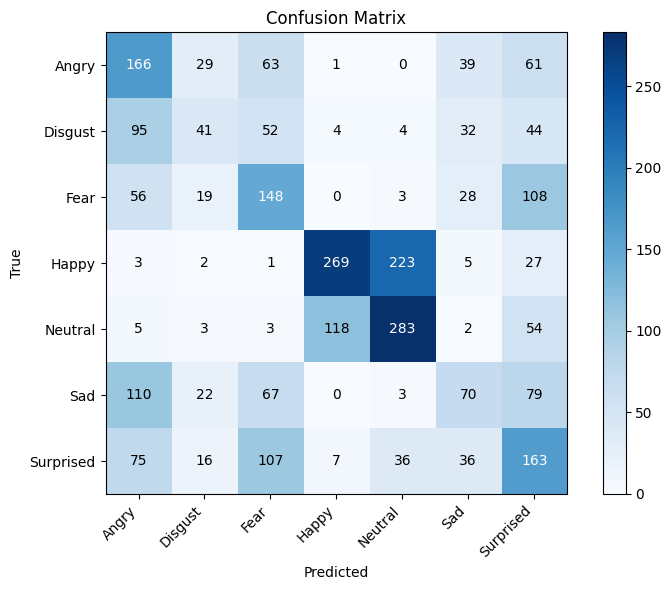

In [36]:
# Recreate test loader
batch_size = 32
img_size = 256
_, _, test_loader = create_dataloaders(
    img_dir=root_dir,
    batch_size=batch_size,
    val_split=0.1,
    test_split=0.1,
    img_size=img_size
)

# Load the last checkpoint
G = model.Generator().to(device)
D = model.Discriminator().to(device)
G.load_state_dict(torch.load('../results/improved/G_epoch50.pth', map_location=device))
D.load_state_dict(torch.load('../results/improved/D_epoch50.pth', map_location=device))
G.eval()
D.eval()

# Visualize real vs. generated (first 8)
imgs, labs = next(iter(test_loader))
imgs, labs = imgs.to(device), labs.to(device)
rand = torch.randint(0, G.label_emb.num_embeddings, (labs.size(0),), device=device)
mask = rand == labs
rand[mask] = (rand[mask] + 1) % G.label_emb.num_embeddings

with torch.no_grad():
    fakes = G(imgs, rand)

pairs = torch.cat([imgs[:8], fakes[:8]], dim=0)
grid = make_grid((pairs + 1) / 2, nrow=8)
plt.figure(figsize=(12, 3))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('Top: real   |   Bottom: transformed')
plt.show()

# Compute accuracy on full test set
all_preds = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        _, logits = D(xb)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(yb.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
accuracy = (all_preds == all_labels).float().mean().item()
print("")
print(f"Discriminator test accuracy: {accuracy * 100:.2f}%")
print("")

# Plot confusion matrix manually
base_ds = getattr(test_loader.dataset, 'dataset', test_loader.dataset)
class_names = base_ds.classes
num_classes = len(class_names)

# build confusion matrix
cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
for t, p in zip(all_labels, all_preds):
    cm[t, p] += 1
cm = cm.numpy()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticks(range(num_classes))
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

thresh = cm.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        color = 'white' if cm[i, j] > thresh else 'black'
        ax.text(j, i, int(cm[i, j]), ha='center', va='center', color=color)

plt.tight_layout()
plt.show()

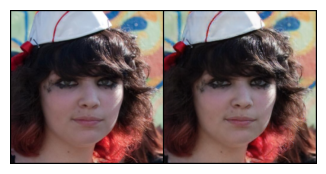

In [39]:
# Inference
G.to(device).eval()

# Pick the first image in a random batch
real_imgs, real_lbls = next(iter(test_loader)) # real_imgs: (B,3,H,W), real_lbls: (B,)
inp_img  = real_imgs[0].unsqueeze(0).to(device) # inp_img: (1,3,H,W)
orig_lbl = real_lbls[0].item()

# Choose a different target label
num_classes = G.label_emb.num_embeddings
tgt_lbl = torch.tensor([ (orig_lbl + 1) % num_classes ], device=device)

# Run the generator
with torch.no_grad():
    out_img = G(inp_img, tgt_lbl) # out_img: (1,3,H,W)

# Denormalize and display side by side
inp_vis = (inp_img  + 1) / 2
out_vis = (out_img  + 1) / 2
comp    = make_grid([inp_vis[0], out_vis[0]], nrow=2)

plt.figure(figsize=(4,2))
plt.imshow(comp.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()

## Conclusions

Despite the best efforts, several factors prevented from fully attaining the goal of seamless, identity-preserving expression translation. First, the inherent class imbalance in AffectNetHQ meant under-represented expressions (e.g., Disgust, Sad) received fewer examples, making it hard for the generator to learn those subtleties even with class-weighted losses. 

Second, the trade-off between altering facial musculature and preserving fine identity details proved challenging (extreme edits often introduced minor artifacts around eyes and mouths, which our reconstruction and perceptual losses only partially alleviated). 

Third, limited time constrained how deeply we could tune hyperparameters and explore larger architectures or multi-scale attention mechanisms. 

Finally, our evaluation relied on a PatchGAN discriminator’s classifier—while useful, it struggles to capture perceptual realism as humans perceive it, so high quantitative accuracy didn’t always translate to visually flawless edits. Together, these bottlenecks underscored the difficulty of learning very subtle, high-fidelity expression changes within the scope of this project.

## References

[1] Zhu, Jun-Yan, et al. “Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.” ICCV 2017.\
[2] Isola, Phillip, et al. “Image-to-Image Translation with Conditional Adversarial Networks.” CVPR 2017.\
[3] Choi, Yunjey, et al. “StarGAN: Unified Generative Adversarial Networks for Multi-Domain Image-to-Image Translation.” CVPR 2018.\
[4] Choi, Yunjey, et al. “StarGAN v2: Diverse Image Synthesis for Multiple Domains.” CVPR 2020.\
[5] Mollahosseini, Ali, et al. “AffectNet: A Database for Facial Expression, Valence, and Arousal Computing in the Wild.” IEEE Transactions on Affective Computing 2017.\
[6] Liu, Ziwei, et al. “Large-Scale CelebFaces Attributes (CelebA) Dataset.” 2015.\